In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv


In [2]:
# I use these libraries
!pip install pyswarms
#!pip install pycaret --ignore-installed llvmlite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 482.7 kB/s eta 0:00:00


In [3]:
import pyswarms as ps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv",sep=";")
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## So, this Dataset contains the following Features :

* id => It's just the Id no of the row. Not revelant
* age => It's the age of a person in Days
* gender => It's the gender of the person
* height => It's the height of the person in cm
* weight => It's the weight of the person in kg
* ap_hi => It's the Systolic blood pressure i.e. Pressure exerted when Blood is ejected in arteries. Normal value : 120mmhg or Below
* ap_low => It's the Diastolic blood pressure i.e. Pressure exerted when Blood exerts between arteries and heartbeats. Normal Value : 80mmhg or Below
* cholesterol :> It's the Cholestreol value (Cholesterol is a type of fat found in your blood) of your blood. In Adults, 200 mg/dL is desired with 200 and 239 mg/dL as Boderline High. In Children, 170 mg/dL is desired with 170 and 199 mg/dL as Boderline High
* gluc => It's the Glucose Level. They're less than 100 mg/dL after not eating (fasting) for at least 8 hours. And they're less than 140 mg/dL 2 hours after eating. For most people without diabetes, blood sugar levels before meals hover around 70 to 80 mg/dL
* smoke => It contain Binary Values stating whether Person is a Smoker or not i.e. {0 : 'Not a Smoker', 1 : 'Smoker'}
* alco => It contain Binary Values stating whether Person is an alchoalic or not i.e. {0 : 'Not a Alcholic', 1 : 'Alcholic'}
* active => It contain Binary Values stating whether Person is involved in physical activites or not i.e. {0 : 'Not involved in Physical Activites', 1 : 'involved in physical activites'}
* cardio => It's our Target Value Binary Values stating whether Person has Cardiovascular diseases (CVDs) or Not i.e. {0 : 'Not Have CVD', 1 : 'Have CVD'}


![](https://www.bhf.org.uk/-/media/news-images/2020/october/heart-disease-patient-640x410px.jpg?w=100%25&rev=032af6ee7d5e40388f0d1a2df70e2f3b&hash=559CD8087FF1CF53D2F13EA7BEC7656B)

In [5]:
duplicate_sum = df.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Dataset contains no Duplicate Values


In [6]:
# Seeking to outlier then destroy it!!!
def outliers(df_out, drop = False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(feature_data, 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 #That's we were talking about above
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()  
        print('For the feature {}, No of Outliers is {}'.format(each_feature, len(outliers)))

outliers(df[['height', 'weight']])


For the feature height, No of Outliers is 519
For the feature weight, No of Outliers is 1819


In [7]:
df[['height', 'weight']] = np.log(df[['height', 'weight']])
outliers(df[['height', 'weight']])
df = df[(df['weight'] > df['weight'].quantile(0.005)) & (df['weight'] < df['weight'].quantile(0.995))]
df = df[(df['height'] > df['height'].quantile(0.005)) & (df['height'] < df['height'].quantile(0.995))]
outliers(df[['height', 'weight']])
df["height"] = np.expm1(df["height"])
df["weight"] = np.expm1(df["weight"])
df.shape

For the feature height, No of Outliers is 484
For the feature weight, No of Outliers is 1174
For the feature height, No of Outliers is 0
For the feature weight, No of Outliers is 349


(68370, 13)

In [8]:
# BMI formulation
df["bmi"] = np.round(df.weight/(df.height/100)**2,2)
print(df.shape)
df.head(3)

(68370, 14)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,18393,2,167.0,61.0,110,80,1,1,0,0,1,0,21.87
1,1,20228,1,155.0,84.0,140,90,3,1,0,0,1,1,34.96
2,2,18857,1,164.0,63.0,130,70,3,1,0,0,0,1,23.42


If your BMI is:

* below 18.5 – you're in the underweight range
* between 18.5 and 24.9 – you're in the healthy weight range
* between 25 and 29.9 – you're in the overweight range
* between 30 and 39.9 – you're in the obese range

[Reference:](https://www.nhs.uk/common-health-questions/lifestyle/what-is-the-body-mass-index-bmi/)

In [9]:
df.loc[(df.bmi <= 18.4), 'bmicat'] = 1
df.loc[(df.bmi > 18.4) & (df.bmi < 25), 'bmicat'] = 2
df.loc[(df.bmi >= 25) & (df.bmi < 30), 'bmicat'] = 3
df.loc[(df.bmi >= 30) & (df.bmi < 40), 'bmicat'] = 4
df.loc[(df.bmi >= 40), 'bmicat'] = 5

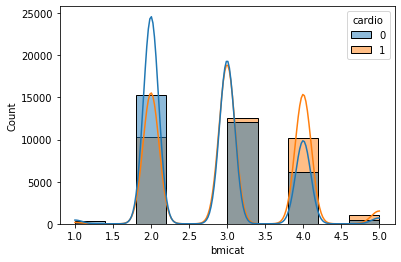

In [10]:
sns.histplot(data=df,x="bmicat",hue="cardio",kde=True,bins=10)
plt.show()

# When the BMI category increases, you can see from the histplot that the risk of cardiovascular disease also increases within the category.

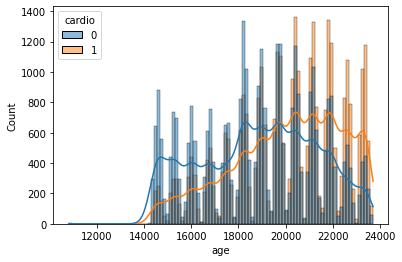

In [11]:
# I handle to age now
sns.histplot(data=df,x="age",hue="cardio",bins=100,kde=True)
plt.show()
# We can say with histplot; Cardiovascular diseases increases with age

In [12]:
# Finding the categorical years

df["year"] = np.round(df.age/365,2)
df.loc[(df.year <= 40), 'agecat'] = 1
df.loc[(df.year > 40)&(df.year<=45), 'agecat'] = 2
df.loc[(df.year > 40)&(df.year<=45), 'agecat'] = 3
df.loc[(df.year > 45)&(df.year<=50), 'agecat'] = 4
df.loc[(df.year > 50)&(df.year<=55), 'agecat'] = 5
df.loc[(df.year > 55)&(df.year<=60), 'agecat'] = 6
df.loc[(df.year > 60)&(df.year<=65), 'agecat'] = 7
df.loc[(df.year > 65)&(df.year<=70), 'agecat'] = 8
df.loc[(df.year >= 70), 'agecat'] = 9

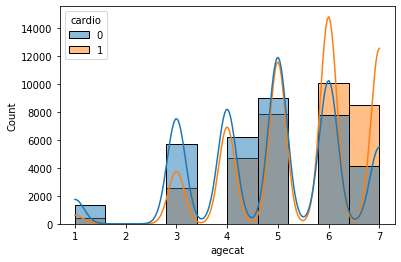

In [13]:
sns.histplot(data=df,x="agecat",hue="cardio",bins=10,kde=True)
plt.show()

In [14]:
# I choose the AHA 2020 hypertension guideline for the categories

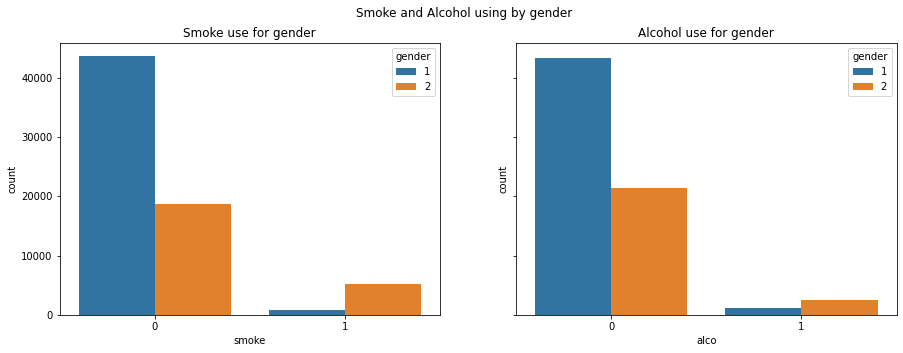

In [15]:
# We already know men have more uses smoke and alcohol rather than women
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Smoke and Alcohol using by gender')

# Bulbasaur
sns.countplot(ax=axes[0], x=df.smoke,hue=df.gender)
axes[0].set_title("Smoke use for gender")

# Charmander
sns.countplot(ax=axes[1], x=df.alco,hue=df.gender)
axes[1].set_title("Alcohol use for gender")
plt.show()
# Gender: 2 is must be men

In [16]:
df.gender.replace(1,"female",inplace=True)
df.gender.replace(2,"male",inplace=True)
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bmicat,year,agecat
0,0,18393,male,167.0,61.0,110,80,1,1,0,0,1,0,21.87,2.0,50.39,5.0
1,1,20228,female,155.0,84.0,140,90,3,1,0,0,1,1,34.96,4.0,55.42,6.0
2,2,18857,female,164.0,63.0,130,70,3,1,0,0,0,1,23.42,2.0,51.66,5.0


In [17]:
# Some conditions are incompatible with normal life.

out_filter = ((df["ap_hi"]>180) | (df["ap_lo"]>150))
df = df[~out_filter]
out_filter2 = ((df["ap_hi"] < 60) | (df["ap_lo"] < 30))
df = df[~out_filter2]

# Some cases diastolic pressure is higher than systolic, it is impossible with normal physiologic condition. 
df = df[~(df['ap_lo']> df['ap_hi'])]

print(df.shape)

(66826, 17)


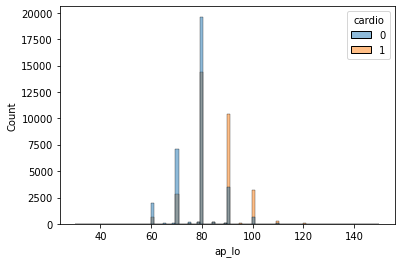

In [18]:
sns.histplot(data=df,x="ap_lo",hue="cardio",bins=100)
plt.show()

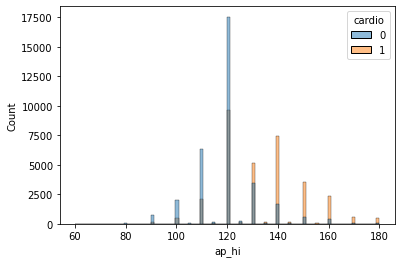

In [19]:
sns.histplot(data=df,x="ap_hi",hue="cardio",bins=100)
plt.show()


## I use hypertension classification from AHA 2020 guideline

![Class](https://www.ahajournals.org/cms/asset/aa0918b0-c2f8-4b8e-b973-863fe8f39437/hypertensionaha.120.15026.tab06.gif)

In [20]:
# Find the risk number
risk_number = []
for i in range(len(df)):
    total = []
    if df.agecat.iloc[i]>8:
        total.append(1)
    if df.gluc.iloc[i]>1:
        total.append(1)
    if df.cholesterol.iloc[i]>1:
        total.append(1)
    if df.bmicat.iloc[i]>=3:
        total.append(1)
    if df.active.iloc[i]==0:
        total.append(1)
    if df.alco.iloc[i] == 1:
        total.append(1)
    if df.smoke.iloc[i] == 1:
        total.append(1)
    risk_number.append(np.sum(total))

df["risk_number"] = risk_number

hypertension_grade = []
for i in range(len(df)):
    if df.ap_hi.iloc[i]<140 and df.ap_lo.iloc[i]<90:
        if df.risk_number.iloc[i] >=3:
            hypertension_grade.append(3)
        else:
            hypertension_grade.append(1)
    elif df.ap_hi.iloc[i]>=160 and df.ap_lo.iloc[i]>=100:
        if df.risk_number.iloc[i]>0:
            hypertension_grade.append(3)
        else:
            hypertension_grade.append(2)
    else:
        if df.risk_number.iloc[i] < 1:
            hypertension_grade.append(1)
        elif df.risk_number.iloc[i] >= 3:
            hypertension_grade.append(3)
        else:
            hypertension_grade.append(2)


df["hyper_tension_gr"] = hypertension_grade

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bmicat,year,agecat,risk_number,hyper_tension_gr
0,0,18393,male,167.0,61.0,110,80,1,1,0,0,1,0,21.87,2.0,50.39,5.0,0.0,1
1,1,20228,female,155.0,84.0,140,90,3,1,0,0,1,1,34.96,4.0,55.42,6.0,2.0,2
2,2,18857,female,164.0,63.0,130,70,3,1,0,0,0,1,23.42,2.0,51.66,5.0,2.0,1
3,3,17623,male,168.0,81.0,150,100,1,1,0,0,1,1,28.70,3.0,48.28,4.0,1.0,2
4,4,17474,female,155.0,55.0,100,60,1,1,0,0,0,0,22.89,2.0,47.87,4.0,1.0,1


### [I create a function from uptodate](https://www.uptodate.com/contents/calculator-cardiovascular-risk-assessment-10-year-men-patient-education)
* This formulation is undependent to race

![General formula](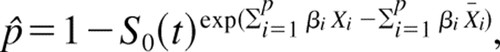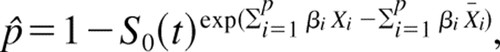)
#### For male

![male](https://www.ahajournals.org/cms/asset/531afbba-3e45-4d08-90e5-41f307a44fdf/14mm6.jpg)

#### For female

![female](https://www.ahajournals.org/cms/asset/f6fd98d3-4c43-4f6a-ba92-5a413f0d751a/14mm2.jpg)

* [More detailed formulation in here:](https://www.ahajournals.org/doi/10.1161/CIRCULATIONAHA.107.699579?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)

In [21]:
cvr=[]

# This formulations's limitation is we dont know about real cholestrol levels

for i in range(len(df)):
    if df["gender"].iloc[i] == "female":
        a=df.year.iloc[i]
        b=df.cholesterol.iloc[i]
        c=df.ap_hi.iloc[i]
        d=df.hyper_tension_gr.iloc[i] 
        e=df.smoke.iloc[i]
        f=df.gluc.iloc[i]
        if d >= 1:
            On_blood_pressure_medication = 1
        if d == 1:
            On_blood_pressure_medication = 0
        if b==1:
            totalcol=200
            hdl=40
        if b==2:
            totalcol=350
            hdl=60
        if b==3:
            totalcol=400
            hdl=80
        if f>1:
            f=1
        if On_blood_pressure_medication == 0:
            nontreated=1
        if On_blood_pressure_medication == 1:
            nontreated=0
        Risk_Factors = np.exp((np.log(a) * 2.32888) + (np.log(totalcol * 1.20904) - np.log(hdl * 0.70833) + (np.log(c)* nontreated * 2.76157)+(2.82263*On_blood_pressure_medication*np.log(c))) + (e*0.52873) + (f*0.69154) - 26.1931)    
        
        risk = (100 * (1 -(0.95012**Risk_Factors)))
        cvr.append(risk)
    
    
    if df["gender"].iloc[i] == "male":
        a=df.year.iloc[i]
        b=df.cholesterol.iloc[i]
        c=df.ap_hi.iloc[i]
        d=df.hyper_tension_gr.iloc[i] 
        e=df.smoke.iloc[i]
        f=df.gluc.iloc[i]
        if d >= 1:
            On_blood_pressure_medication = 1
        if d == 1:
            On_blood_pressure_medication = 0
        if b==1:
            totalcol=200
            hdl=40
        if b==2:
            totalcol=300
            hdl=60
        if b==3:
            totalcol=400
            hdl=80
        if f>1:
            f=1
        if On_blood_pressure_medication == 0:
            nontreated=1
        if On_blood_pressure_medication == 1:
            nontreated=0
        Risk_Factors = np.exp((np.log(a) * 3.06117) + (np.log(totalcol) * 1.12370) - (np.log(hdl)* 0.93262) + ((np.log(c)* nontreated * 1.93303)+(1.99881*On_blood_pressure_medication*np.log(c))) + (e*0.65451) + (f*0.57367)-23.9802)
        risk = (100 * (1 -(0.88936**Risk_Factors)))
        cvr.append(risk)
    #print(a,b,c,d,e,f,nontreated,On_blood_pressure_medication,totalcol,hdl)

df["Risk_score"]=cvr

### When I evaluated the risk estimation based on the Cox model, I did not use it because it does not work properly and does not create a high performance model.

[Refence](https://www.ahajournals.org/doi/10.1161/CIRCULATIONAHA.107.699579?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)

### This prediction score wasn't help to discriminate variables.

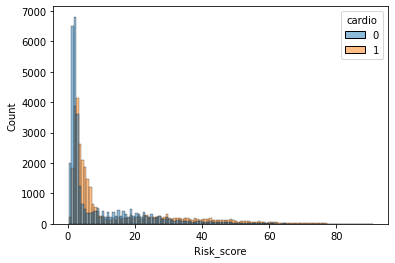

In [22]:
sns.histplot(data=df,x=df.Risk_score,hue=df.cardio)
plt.show()

In [23]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bmicat,year,agecat,risk_number,hyper_tension_gr,Risk_score
0,0,18393,male,167.0,61.0,110,80,1,1,0,0,1,0,21.87,2.0,50.39,5.0,0.0,1,13.246457
1,1,20228,female,155.0,84.0,140,90,3,1,0,0,1,1,34.96,4.0,55.42,6.0,2.0,2,4.710407
2,2,18857,female,164.0,63.0,130,70,3,1,0,0,0,1,23.42,2.0,51.66,5.0,2.0,1,2.438717
3,3,17623,male,168.0,81.0,150,100,1,1,0,0,1,1,28.70,3.0,48.28,4.0,1.0,2,27.070496
4,4,17474,female,155.0,55.0,100,60,1,1,0,0,0,0,22.89,2.0,47.87,4.0,1.0,1,0.996806


In [24]:
# Let's the drop dependent columns;
df.drop(columns=["id","age","height","weight","ap_hi","ap_lo","bmi","year","Risk_score","risk_number"],inplace=True)
df.head(3)

,gender,cholesterol,gluc,smoke,alco,active,cardio,bmicat,agecat,hyper_tension_gr
0,male,1,1,0,0,1,0,2.0,5.0,1
1,female,3,1,0,0,1,1,4.0,6.0,2
2,female,3,1,0,0,0,1,2.0,5.0,1


In [25]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df.gender = le.fit_transform(df.gender)
df.head(3)

,gender,cholesterol,gluc,smoke,alco,active,cardio,bmicat,agecat,hyper_tension_gr
0,1,1,1,0,0,1,0,2.0,5.0,1
1,0,3,1,0,0,1,1,4.0,6.0,2
2,0,3,1,0,0,0,1,2.0,5.0,1


In [26]:
df = pd.get_dummies(df,columns=['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmicat',
       'agecat', 'hyper_tension_gr'],drop_first=True)
df.head()

,cardio,gender_1,cholesterol_2,cholesterol_3,gluc_2,gluc_3,smoke_1,alco_1,active_1,bmicat_2.0,bmicat_3.0,bmicat_4.0,bmicat_5.0,agecat_3.0,agecat_4.0,agecat_5.0,agecat_6.0,agecat_7.0,hyper_tension_gr_2,hyper_tension_gr_3
0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0
1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0
2,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [27]:
X = df.copy()
y = X.cardio
X.drop(columns="cardio",inplace=True)
X.shape,y.shape

((66826, 19), (66826,))

In [28]:
from sklearn.model_selection import StratifiedKFold, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=42)
#train = pd.concat([X_train,y_train],axis=1)
#test = pd.concat([X_test,y_test],axis=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((46778, 19), (20048, 19), (46778,), (20048,))

![pycaret result](https://pbs.twimg.com/media/FW0vrfwWAAQ4Lwc?format=jpg&name=large)

### I think that, if PSO algorithms will find more than 70% accuracy it is very well.

In [29]:
X_train = X_train.values
y_train = y_train.values
X_train.shape,y_train.shape

((46778, 19), (46778,))

# Particles Swarm Optimization in Case

* Last week, I prepared a tutorial on Particle Swarm Optimization and created and shared a notebook with the relevant Benchmark tests. This week we will use this algorithm with real world data.
    * [Tutorial link](https://www.kaggle.com/code/zzettrkalpakbal/particle-swarm-optimization-benchmark-tests)
    
![foto](https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13762-018-1970-x/MediaObjects/13762_2018_1970_Fig1_HTML.png?as=webp)    





* Recall that neural networks can simply be seen as a mapping function from one space to another. For now, we’ll build a simple neural network with the following characteristics: 
    
    * Input layer size: 19 
    * Hidden layer size: 20 (activation: tanh(x)) 
    * Output layer size: 2 (activation: softmax(x))


* Things we’ll do: 
    1. Create a forward_prop method that will do forward propagation for one particle. 
    2. Create an overhead objective function f() that will compute forward_prop() for the whole swarm.

* What we’ll be doing then is to create a swarm with a number of dimensions equal to the weights and biases. We will unroll these parameters into an n-dimensional array, and have each particle take on different values. Thus, each particle represents a candidate neural network with its own weights and bias. When feeding back to the network, we will reconstruct the learned weights and biases.

* When rolling-back the parameters into weights and biases, it is useful to recall the shape and bias matrices: 
    * Shape of input-to-hidden weight matrix: (19, 20) 
    * Shape of input-to-hidden bias array: (20, ) 
    * Shape of hidden-to-output weight matrix: (20, 2) 
    * Shape of hidden-to-output bias array: (2, )

* By unrolling them together, we have; 
    * (19∗20)+(20∗2)+20+2=442 parameters, or 442 dimensions for each particle in the swarm.

* The negative log-likelihood will be used to compute for the error between the ground-truth values and the predictions. Also, because PSO doesn’t rely on the gradients, we’ll not be performing backpropagation (this may be a good thing or bad thing under some circumstances).

* Now, let’s write the forward propagation procedure as our objective function. Let X be the input, zl the pre-activation at layer l, and al the activation for layer l:

In [30]:
n_inputs = X_train.shape[1]
n_hidden = 20
n_classes = 2
num_samples = len(X_train)
iteration = 1000

In [31]:
a = n_inputs*n_hidden
b = a+n_hidden
c = b+(n_hidden*n_classes)
d = c+n_classes

In [32]:
def logits_function(p):
    """ Calculate roll-back the weights and biases

    Inputs
    ------
    p: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    numpy.ndarray of logits for layer 2

    """
    # Roll-back the weights and biases
    W1 = p[0:a].reshape((n_inputs,n_hidden))
    b1 = p[a:b].reshape((n_hidden,))
    W2 = p[b:c].reshape((n_hidden,n_classes))
    b2 = p[c:d].reshape((n_classes,))

    # Perform forward propagation
    z1 = X_train.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1
    logits = a1.dot(W2) + b2 # Pre-activation in Layer 2
    return logits          # Logits for Layer 2

In [33]:
# Forward propagation
def forward_prop(params):
    """Forward propagation as objective function

    This computes for the forward propagation of the neural network, as
    well as the loss.

    Inputs
    ------
    params: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    float
        The computed negative log-likelihood loss given the parameters
    """

    logits = logits_function(params)

    # Compute for the softmax of the logits
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute for the negative log likelihood

    corect_logprobs = -np.log(probs[range(num_samples), y_train])
    loss = np.sum(corect_logprobs) / num_samples

    return loss

In [34]:
def f(x):
    """Higher-level method to do forward_prop in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    return np.array(j)

In [35]:
%%time
# Initialize swarm
options = {'c1': 0.8, 'c2': 0.6, 'w':0.9}

# Call instance of PSO
dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=iteration)

2022-07-04 13:19:08,686 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.8, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.584
2022-07-04 15:48:13,222 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5842314678208745, best pos: [ 1.62149699e-01  2.80856884e+00 -3.42636548e-01  2.08372590e-02
 -5.96195211e-02  6.37490619e-01  3.70295241e-01  1.32094077e-01
  4.85014314e-01  1.17367207e+00 -1.20405620e-01 -3.31395903e-01
 -2.25694130e-01  5.71819228e-01  2.83557905e-01 -1.02552844e-01
 -2.51830815e-01  1.77053715e+00  2.04642161e+00  2.52213925e+00
 -9.16457783e-01 -2.25751693e-01  4.07378028e-01 -3.38829261e-01
 -3.94193099e-01  4.00967872e-01  8.32679571e-01 -1.17482802e-01
  8.25396169e-01  3.80183223e-01 -3.66366506e-02 -2.50177196e-02
  6.03734924e-01  1.02138155e-01  4.19685446e-01  6.17793285e-01
 -3.56679290e-01 -1.41800659e-01  1.07870530e+00  1.55278806e-02
  8.79499581e-01  5.93191

CPU times: user 5h 1min 16s, sys: 4h 43min 13s, total: 9h 44min 29s
Wall time: 2h 29min 4s


In [36]:
def predict(pos):
    """
    Use the trained weights to perform class predictions.

    Inputs
    ------
    pos: numpy.ndarray
        Position matrix found by the swarm. Will be rolled
        into weights and biases.
    """
    logits = logits_function(pos)
    y_pred = np.argmax(logits, axis=1)
    return y_pred
    

In [37]:
(predict(pos) == y_train).mean()

0.7021249305228954

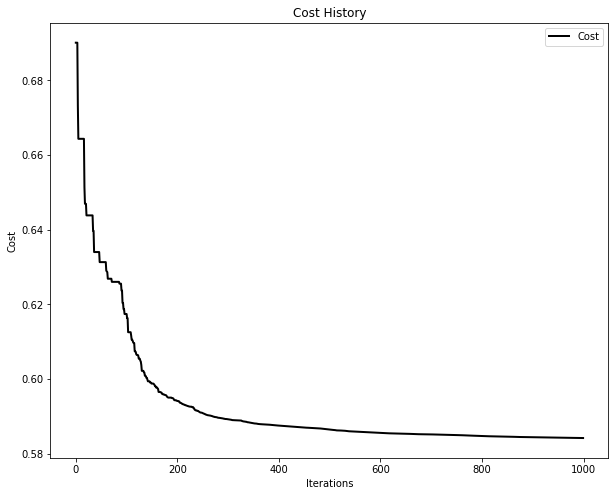

In [38]:
from pyswarms.utils.plotters.formatters import Mesher
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import matplotlib.pyplot as plt
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

As a result, it performed as well as other models. The worst disadvantage is the time! It takes almost four hours to run. Therefore, this algorithm still has a long way to go. However, it provides an alternative to standard algorithms.

See you on new notebooks.

![a](https://sd.keepcalms.com/i-w600/please-follow-me-and-like-this.jpg)